## HW6 - João Lazzaro

This file solves a simple version of AMSS - Optimal Taxation without State-Contingent debt. The instructions were to solve a version of the model with iid shocks and no Transfers, and shocks that takes 2 values. This is the case I do but this code should work for the case in which the stochastic process follows a Markov Chain and takes more than 2 values. To be more precise, I solve the following model: 

The government must finance an exogenous random expenditure $g$ following a Markov Process using labor taxes $\tau$ and risk free bonds $b$. The representative household is assumed to have separable utility in labor and consumption and solves the problem:

$$ \max_{\{c_t,b_t\}_{t=0}^\infty} E_0\sum_{t=0}^\infty \beta^t \left(u(c_t) + v(n_t)\right)$$
The budget constraint is: $$c_t + b_{t+1} p_t = n_t(1-\tau_t) + b_t $$

The feasibility constraint is: $c_t +g_t = n_t$. And the government budget constraint is:  $$g_t +  b_t= b_{t+1} p_t  +n_t\tau_t$$

We are looking for a Ramsey equilibrium in which the government chooses taxes and debt to choose the best competitive equilibrium. The standard approach involves finding the implementability constraint and this can be done so we get the Ramsey problem:

$$ \max_{\{c_t,b_t\}_{t=0}^\infty} E_0\sum_{t=0}^\infty \beta^t \left(u(c_t) + v(n_t)\right)$$

$$ E_t\left(\beta b_{t+1} u'(c_{t+1})\right) \geq u'(c_t)(b_t-c_t) - e_t v'(n_t) $$

 $n_t = c_t+g_t$ and $b_0$ is given

From this point on, my approach slightly differs from AMSS. I follow Marimon and Marcet (2019) - Recursive Contracts approach. They show that this problem is a case of a class of problems which can be shown to be a solution of a Saddle Point functional equation. The authors prove that a solution to this Ramsey problem is equivalent to a solution to:

$$W(b,\mu,g) = \min_\gamma \max_{c,b'} u(c) +v(n) + \mu b u'(c) + \gamma \left(u'(c)(c-b) + n v'(n)\right) + \beta E\left[W(b',\gamma,g'|g)\right]$$

With $b_0$ given and $\mu_0 = 0$.

I solve this problem using a simple discrete state space method and the algorithm is identical to Value function iteration. To compare my results I use the same parameters and utility function as the QuantEcon example found in: https://lectures.quantecon.org/jl/dynamic_programming_squared/amss.html

In this case, $g$ is iid and takes 2 values. My goal is therefore to replicate, with my own code, the picture generated using their codes:

diff = 0.0007972370742072324
diff = 0.0006423564078811113
diff = 0.0005517451322767461
diff = 0.00048544556800011237
diff = 0.0004225956362995086
diff = 0.0003752402045607622
diff = 0.00032923024839060893
diff = 0.00029301092508205443
diff = 0.00025828133556186477
diff = 0.00023004988554156664
diff = 0.00020339511000220156
diff = 0.00018119904947256954
diff = 0.00016054379291212251
diff = 0.00014301160913399787
diff = 0.00012690844111525496
diff = 0.00011302967577132756
diff = 0.00010042592314122275
diff = 8.941313041166441e-5


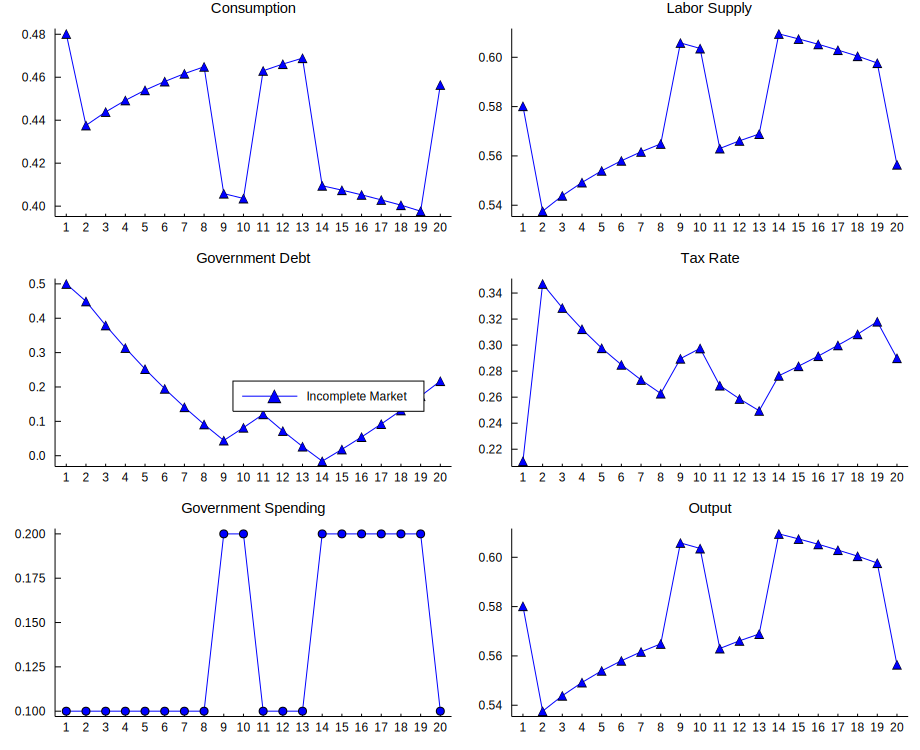

In [3]:
include("QEplots.jl")

 Let's define the functions used in my code (the functions below conflict with the Quant Econ function above, so Shut down Kernel to continue from here):

In [1]:
#Consumption function comes from feasibility constraint:
consumption(n,g) = n - g

#The non dynamic part of the SP problem
function V(n,γ,b,g,μ)
    c = consumption(n,g)
    UC = Uc(c,n)
    UN = Un(c,n)
    V = U(c,n) +μ*b*UC+γ*(UC*(c-b)+n*UN)
    return V
end

#The optimal labor choice:
nstar(γ,b,g,μ) = optimize(n-> -V(n,γ,b,g,μ) ,g,1.0).minimizer
Vstar(γ,b,g,μ) = V(nstar(γ,b,g,μ),γ,b,g,μ)

Vstar (generic function with 1 method)

In [2]:
#The expected Value function:
function EW(b1,μ1,g,Wgrid;Π=Π)


    g0 = findfirst(G.==g)
    bi = findfirst(B.==b1)
    μi = findfirst(μ.==μ1)

    expected::Float64 =0.0
    for gi = 1:nG
        expected += Π[g0,gi]*Wgrid[bi,μi,gi]
    end
    return expected
end

EW (generic function with 1 method)

The function below implements value function iteration for the Saddle Point functional equation above using discrete state space. The method is slow but it was easy to implement. Interpolations and other numerical tricks could improve the speed and accuracy of results.

In [3]:
function SPFE(B,G,μ;nB=nB,nG=nG,nμ=nμ,β=β,Wgrid = Wgrid = ones(nB,nμ,nG))
    #= Inputs:
    Wgrid: Guess for value function
    B: Grid for debt
    G: Grid for government expenditures
    μ: Grid for the Lagrange Multiplier
    =#

    #= Outputs:
    Wgrid: Value Function
    policy: Policy functions
    =#

    #Preallocating stuff
    Wgrid1::Array{Float64,3}=copy(Wgrid) #to store updated values
    objective::Array{Float64,2} = ones(nμ,nB) #This will be the function min maxed
    policy::Array{Int64,4} = ones(Int64,nB,nμ,nG,2) #This will store the policy functions
    dist::Float64 =1.0 #Distance
    Vstargrid::Array{Float64,4} = ones(nB,nμ,nG,nμ) #This is the grid for the non0dynamic part of the SP problem
    EWgrid::Array{Float64,3} = ones(nB,nμ,nG) #This is the grid the expected value function
    #find the grid for the non dynamic part
    for γi=1:nμ,gi = 1:nG, μi = 1:nμ , bi = 1:nB
        Vstargrid[bi,μi,gi,γi] = Vstar(μ[γi],B[bi],G[gi],μ[μi])
    end

    while dist>1e-5
        #find the grid of the new guess, for each possible value of γ and b1
        for gi = 1:nG, γi = 1:nμ,b1 = 1:nB
            EWgrid[b1,γi,gi] = EW(B[b1],μ[γi],G[gi],Wgrid)
        end
            for gi = 1:nG,μi = 1:nμ ,bi = 1:nB
                #Joun the dynamic with non dynamic parts
                for γi=1:nμ, b1i=1:nB
                    objective[γi,b1i] = Vstargrid[bi,μi,gi,γi] +β * EWgrid[b1i,γi,gi]
                end
                ob2,indsB =findmax(objective,dims=2) #find the inner maximum of the SP problem
                Wgrid1[bi,μi,gi],indsμ = findmin(ob2) #find the outer minimum
                policy[bi,μi,gi,2] = indsμ[1] #get the policy indexes
                policy[bi,μi,gi,1] = indsB[indsμ[1]][2]
            end
        dist = maximum(abs.(Wgrid.-Wgrid1)) #chech convergence
        #println("distance is $(dist)")
        Wgrid = 0.75*Wgrid1+0.25*Wgrid
    end
    return Wgrid,policy
end

SPFE (generic function with 1 method)

Now let's define the parameters we use (taken from Quant Econ):

In [4]:
using Optim, Interpolations
#Defining parameters
β = 0.9
ψ = 0.69
Π = 0.5 * ones(2, 2)
G = [0.1, 0.2]
# Derivatives of utility function
U(c,n;ψ=ψ) = log(c) + ψ * log(1 - n)
Uc(c,n) = 1 ./ c
Un(c,n;ψ=ψ) = -ψ ./ (1.0 .- n)

#Defining grids
nμ = 50
nB = 120
B = range(-1.0,stop=1.5,length = nB)
μ = range(0,stop = .55,length = nμ)

nΠ = length(Π)
nG = length(G)

2

The utility function used here is CRRA, but any GHH utility function would work with my code. I solve the problem using 50 gridpoint for the Lagrange Multiplier $\mu$ and 120 points for debt $b$. The code is extremely sensitive for both the size and boundaries of the equally spaced grid. Now, we get the policy functions using the SPFE function defined above.

In [5]:
#Solve the saddle point problem:
Wgrid,policy = SPFE(B,G,μ;nB=nB,nG=nG,nμ=nμ);

Now, we may simulate the economy and plot the results:

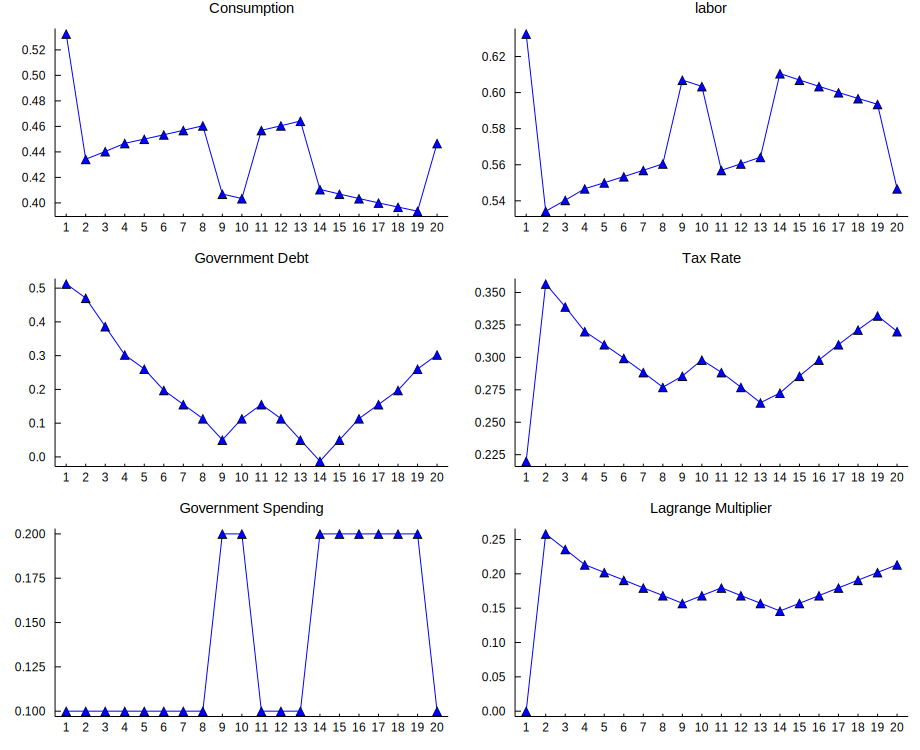

In [30]:
#Simulate and plot the economy:
T = 20
Ghist = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1]
b0 = .50
μ0 = 0.

Bhist = fill(findfirst(B.>=b0),T)
μhist = fill(findfirst(μ.>=μ0),T)
nhist = ones(T)


for t = 2:T
    Bhist[t] = policy[Bhist[t-1],μhist[t-1],Ghist[t-1],1]
    μhist[t] = policy[Bhist[t-1],μhist[t-1],Ghist[t-1],2]
end

for t=1:T
    nhist[t] = nstar(μ[μhist[t]],B[Bhist[t]],G[Ghist[t]],μ[μhist[t]])
end

Bhist = B[Bhist]
Ghist = G[Ghist]
μhist = μ[μhist]

chist = nhist .-Ghist

tauhist = 1 .+ Un.(chist,nhist) ./ (1. * Uc.(chist,nhist))
tauhist[1] = 0.22


using Plots


titles = hcat("Consumption","labor","Government Debt","Tax Rate","Government Spending", "Lagrange Multiplier")
p = plot(size = (920, 750), layout = grid(3, 2),
         xaxis=(0:T), grid=false, titlefont=Plots.font("sans-serif", 10))
plot!(p, title = titles, legend=false)
plot!(p[1], chist, marker=:utriangle, color=:blue)
plot!(p[2], nhist, marker=:utriangle, color=:blue)
plot!(p[3], Bhist, marker=:utriangle, color=:blue)
plot!(p[4], tauhist, marker=:utriangle, color=:blue)
plot!(p[5], Ghist, marker=:utriangle, color=:blue)
plot!(p[6], μhist, marker=:utriangle, color=:blue)

Note that the graphs are nearly identical to the QuantEcon ones. The only notable difference is that my tax rate in period 1 is close to zero. Tax rate should equate to the marginal utility of labor and consumption ratio. I don't know how they got their result for period 1. For the other periods, the values are nearly the same. I plot here a zoomed tax graph to compare my results. Also, instead of plotting Output, which is redundant with labor, I plot the Lagrange multiplier implied by the model. 

### 3 non-iid States

Now, just for fun, I simulate an economy with 3 levels of expenditure: low, medium and high $G = (0.1,0.15,0.22) $. But since governments in some developing countries insist they are rich and can expend a lot, the probability of the low state is small. The transition matrix is as follows:

$$\Pi = \begin{bmatrix} 
1/6 & 3/6 & 2/6 \\
1/6 & 3/6 & 2/6 \\
1/6 & 2/6 & 3/6
\end{bmatrix}$$

In [31]:
#3 values non iid:

Π = [1/6 3/6 2/6; 1/6 3/6 2/6; 1/6 2/6 3/6]
G = [0.1, 0.15, 0.22]
nμ = 50
nB = 120
B = range(-1.0,stop=1.5,length = nB)
μ = range(0,stop = .55,length = nμ)

nΠ = length(Π)
nG = length(G)


#Solve the saddle point problem:
Wgrid,policy = SPFE(B,G,μ;nB=nB,nG=nG,nμ=nμ);

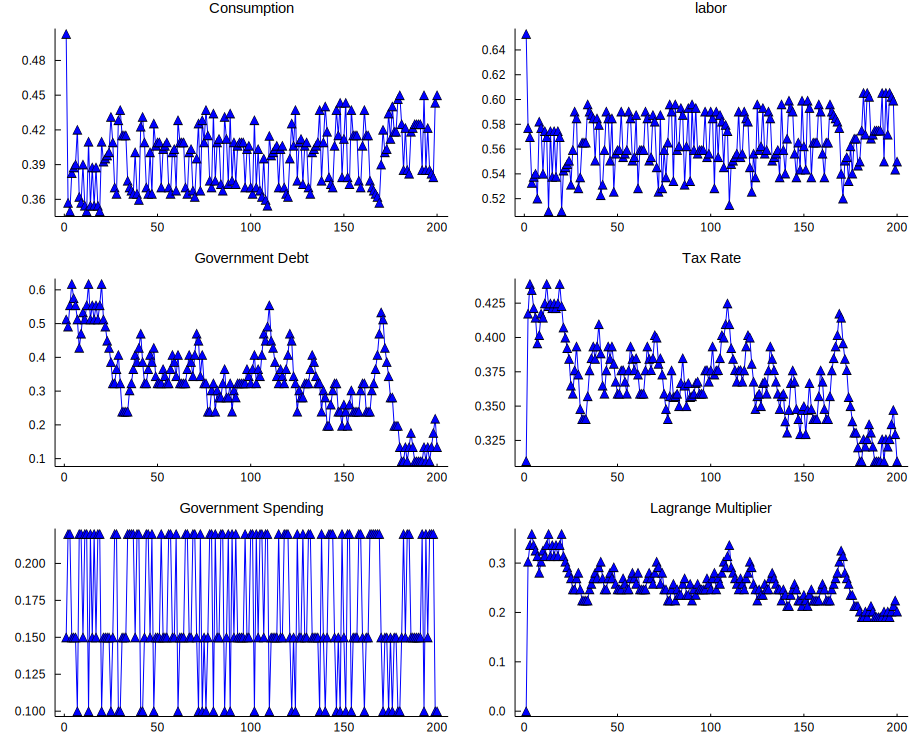

In [12]:
#Simulate the economy:
T = 200

#Simulate the shocks:
Ghist = ones(Int64,T)*2
for t = 2:T
    global Ghist
    g0 = findfirst(G.==G[Ghist[t-1]])
    s = rand()

    g1 = 1
    p = Π[g0,1]
    while s>p
        g1 += 1
        p += Π[g0,g1]
    end
    Ghist[t] = g1
end
t=2
Ghist

b0 = .50
μ0 = 0.0

Bhist = fill(findfirst(B.>=b0),T)
μhist = fill(findfirst(μ.==μ0),T)
nhist = ones(T)
for t = 2:T
    Bhist[t] = policy[Bhist[t-1],μhist[t-1],Ghist[t-1],1]
    μhist[t] = policy[Bhist[t-1],μhist[t-1],Ghist[t-1],2]
end

for t=1:T
    nhist[t] = nstar(μ[μhist[t]],B[Bhist[t]],G[Ghist[t]],μ[μhist[t]])
end

Bhist = B[Bhist]
Ghist = G[Ghist]
μhist = μ[μhist]

chist = nhist .-Ghist

tauhist = 1 .+ Un.(chist,nhist) ./ (1. * Uc.(chist,nhist))
tauhist[1] =0.31

#Plot the economy
using Plots
titles = hcat("Consumption","labor","Government Debt","Tax Rate","Government Spending", "Lagrange Multiplier")
p = plot(size = (920, 750), layout = grid(3, 2),
          grid=false, titlefont=Plots.font("sans-serif", 10))
plot!(p, title = titles, legend=false)
plot!(p[1], chist, marker=:utriangle, color=:blue)
plot!(p[2], nhist, marker=:utriangle, color=:blue)
plot!(p[3], Bhist, marker=:utriangle, color=:blue)
plot!(p[4], tauhist, marker=:utriangle, color=:blue)
plot!(p[5], Ghist, marker=:utriangle, color=:blue)
plot!(p[6], μhist, marker=:utriangle, color=:blue)

Note that the increase in government indebtedness happens simultaneously with the increase in tax rate. The government is forced to tax the housold whenever it faces a prolonged expenditure period and agents work less in response. But note that whenever there is some periods with low levels of expenditures, taxation and indebtedness decreas 